# Test Microphone Input
This notebook tests the re-routing of audio output back into the microphone input channel on a sound card (ASUS Xonar SE 5.1) both with and without an adapter circuit bridging the connection.

## Initial setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile

## Experiment details

The adapter circuit compromises the following diagram:

<img src="MicCircuit.png" alt="drawing" width="400"/>

We varied the different resistor and capacitor values as follows:

Test # |  R1  |  R2  |  R3  |  R4  |  C1  
-------|------|------|------|------|------
1      | 330  | 15k  | 3.3k | 330  | 100nF
2      | 330  | 15k  | 3.3k | 330  | 1nF
3      | 330  | 15k  | 3.3k | 330  | 10pF
4      | 330  | 15k  | 10k  | 330  | 100nF

A dummy run through the behavior setup generated tone cloud, pink noise, and pure tones in each audio channel (left/right) for each set of values. The audio output sent to left/right speakers was split into the adapter circuit above, which then sent the filtered signal to the mic input on the same sound card.

## Spectrogram results
Below, we plot the spectrogram of each test run for each of the two audio channels.

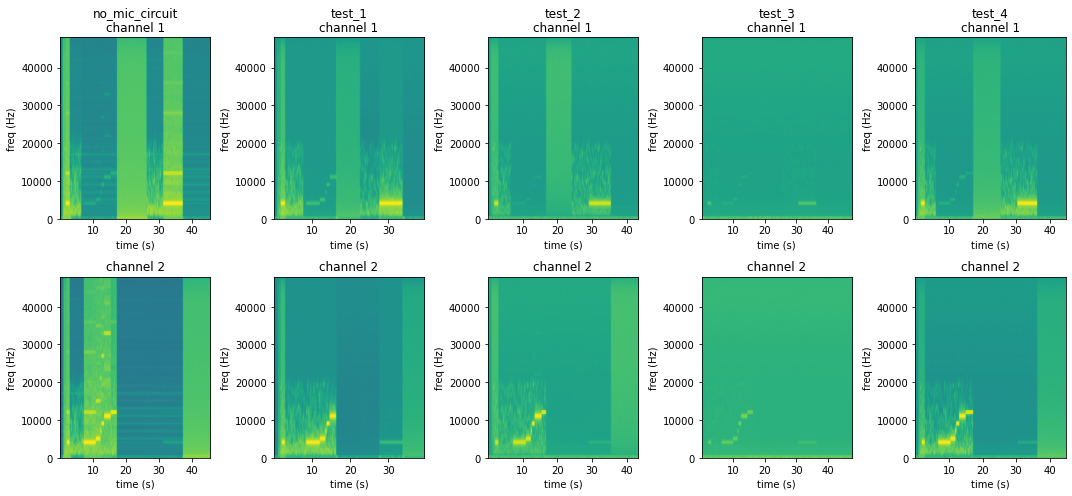

In [2]:
# Data directories for each run
data_dirs = ['no_mic_circuit', 'test_1', 'test_2', 'test_3', 'test_4']

# Create figure
fig, ax = plt.subplots(2, len(data_dirs), figsize=(15, 7))

for i, d in enumerate(data_dirs):
    # Read wav file
    fs, wf = wavfile.read('./{}/StimuliPlayback.wav'.format(d))
    assert wf.shape[1] == 2 # two channels
    
    # Plot spectrogram for each channel
    specs = []
    for j in range(wf.shape[1]):
        spec, freq, t, im = ax[j, i].specgram(wf[:, j], Fs=fs)
        specs.append(spec)
        ax[j, i].set_xlabel('time (s)')
        ax[j, i].set_ylabel('freq (Hz)')
    
    # Label columns
    ax[0, i].set_title('{}\nchannel 1'.format(d))
    ax[1, i].set_title('channel 2')

# Save figure
plt.tight_layout()
plt.savefig('./spectrograms.pdf')

Given the above figure, it appears that parameter set #4 gives the best compromise between filtering crosstalk and preserving signal amplitude.

## PCB testing
The above tests were performed on a solderless breadboard for prototyping. Below, we test the same circuit on a custom PCB (v1.2021) with the following parameters:

  R1  |  R2  |  R3  |  R4  |  C1  
------|------|------|------|------
 330  | 15k  | 15k | 330  | 100nF
 
and play/capture the sound by running a dummy test session with pink noise, tone cloud, and embedded pure tones.

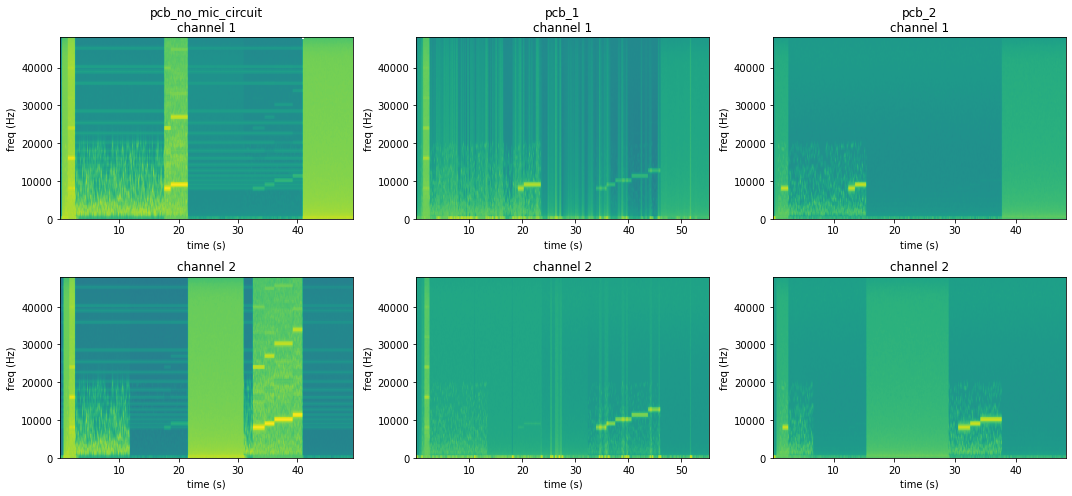

In [13]:
# Data directories for each run
data_dirs = ['pcb_no_mic_circuit', 'pcb_1', 'pcb_2']

# Create figure
fig, ax = plt.subplots(2, len(data_dirs), figsize=(15, 7))

for i, d in enumerate(data_dirs):
    # Read wav file
    fs, wf = wavfile.read('./{}/StimuliPlayback.wav'.format(d))
    assert wf.shape[1] == 2 # two channels
    
    # Plot spectrogram for each channel
    specs = []
    for j in range(wf.shape[1]):
        spec, freq, t, im = ax[j, i].specgram(wf[:, j], Fs=fs)
        specs.append(spec)
        ax[j, i].set_xlabel('time (s)')
        ax[j, i].set_ylabel('freq (Hz)')
    
    # Label columns
    ax[0, i].set_title('{}\nchannel 1'.format(d))
    ax[1, i].set_title('channel 2')
    
# Save figure
plt.tight_layout();

plt.savefig('./pcb_spectrograms.pdf')

Clearly, plugging the audio stimuli line output directly into the mic/line input still has lots of noise. What happened between tests `pcb_1` and `pcb_2`? It turns out that the audio output during `pcb_1` was at or near maximal value, causing clipping of the sound output, which was reflected on the mic capture. By decreasing the SPL by 10 dB, we achieve much cleaner results in the second test, `pcb_2`. In fact, we don't see any more channel crosstalk!